In [96]:
import queue
from experiment_information import *
from experiments.sweep_generalization_error import *
from data import *
from _version import __version__
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_erm = dbHandler.get_erms()
    # delete incomplete experiments (bad, deletes running experiments...)
    dbHandler.delete_incomplete_experiments()
print("Current code version, ", __version__)

Current code version,  18


In [124]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "13"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(2)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,tau,d,erm_methods,completed
35,966d598b-2fc8-45e9-8e75-6c911561ed36,Default Experiment,263.738035,18,2023-04-02 17:22:43,1,3,"[0.2, 0.5, 1.0, 1.5, 2.0, 5.0]","[0.0, 0.01, 0.02, 0.03, 0.04]",[0.001],2.0,300,"[""sklearn""]",1
34,8459c84d-15c9-422a-bca7-00f4e00992a8,Default Experiment,275.441589,18,2023-04-02 17:15:09,1,3,"[0.2, 0.5, 1.0, 1.5, 2.0, 5.0]","[0.0, 0.01, 0.02, 0.03, 0.04]",[1e-05],2.0,300,"[""sklearn""]",1


In [125]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)

966d598b-2fc8-45e9-8e75-6c911561ed36


In [126]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam"])
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error"]]
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes
df = state_evolution.join(gd)
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_error_erm"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3]).agg([np.mean,np.std])
# display all columns
pd.set_option('display.max_columns', None)
df

generalization_error_state_evolution       \
                                                        mean  std   
alpha epsilon tau lam                                               
0.2   0.00    2.0 0.001                             0.478651  0.0   
      0.01    2.0 0.001                             0.478678  0.0   
      0.02    2.0 0.001                             0.478704  0.0   
      0.03    2.0 0.001                             0.478729  0.0   
      0.04    2.0 0.001                             0.478754  0.0   
0.5   0.00    2.0 0.001                             0.469118  0.0   
      0.01    2.0 0.001                             0.469232  0.0   
      0.02    2.0 0.001                             0.469344  0.0   
      0.03    2.0 0.001                             0.469455  0.0   
      0.04    2.0 0.001                             0.469563  0.0   
1.0   0.00    2.0 0.001                             0.461454  0.0   
      0.01    2.0 0.001                             0.461780  0.0   
      0.02    2.0 0.001                             0.462072  0.0   
      0.03    2.0 0.001                             0.462330  0.0   
      0.04    2.0 0.001                             0.462554  0.0   
1.5   0.00    2.0 0.001                             0.457323  0.0   
      0.01    2.0 0.001                             0.457946  0.0   
      0.02    2.0 0.001                             0.458376  0.0   
      0.03    2.0 0.001                             0.458672  0.0   
      0.04    2.0 0.001                             0.458889  0.0   
2.0   0.00    2.0 0.001                             0.453862  0.0   
      0.01    2.0 0.001                             0.455380  0.0   
      0.02    2.0 0.001                             0.455949  0.0   
      0.03    2.0 0.001                             0.456209  0.0   
      0.04    2.0 0.001                             0.456344  0.0   
5.0   0.00    2.0 0.001                             0.412931  0.0   
      0.01    2.0 0.001                             0.413588  0.0   
      0.02    2.0 0.001                             0.414335  0.0   
      0.03    2.0 0.001                             0.415190  0.0   
      0.04    2.0 0.001                             0.416176  0.0   

                        generalization_error_erm_erm            \
                                                mean       std   
alpha epsilon tau lam                                            
0.2   0.00    2.0 0.001                     0.479833  0.007073   
      0.01    2.0 0.001                     0.479260  0.002818   
      0.02    2.0 0.001                     0.475837  0.008184   
      0.03    2.0 0.001                     0.482887  0.008740   
      0.04    2.0 0.001                     0.469760  0.002871   
0.5   0.00    2.0 0.001                     0.473627  0.012462   
      0.01    2.0 0.001                     0.467937  0.008806   
      0.02    2.0 0.001                     0.470430  0.001461   
      0.03    2.0 0.001                     0.469323  0.007389   
      0.04    2.0 0.001                     0.473313  0.007182   
1.0   0.00    2.0 0.001                     0.457443  0.003354   
      0.01    2.0 0.001                     0.452260  0.006004   
      0.02    2.0 0.001                     0.453933  0.005149   
      0.03    2.0 0.001                     0.457753  0.005163   
      0.04    2.0 0.001                     0.452117  0.008122   
1.5   0.00    2.0 0.001                     0.457457  0.001487   
      0.01    2.0 0.001                     0.451533  0.009972   
      0.02    2.0 0.001                     0.448910  0.014988   
      0.03    2.0 0.001                     0.446870  0.008320   
      0.04    2.0 0.001                     0.440930  0.009734   
2.0   0.00    2.0 0.001                     0.455400  0.007666   
      0.01    2.0 0.001                     0.438463  0.004072   
      0.02    2.0 0.001                     0.430737  0.003066   
      0.03    2.0 0.001       

<AxesSubplot: xlabel='alpha,tau,lam'>

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


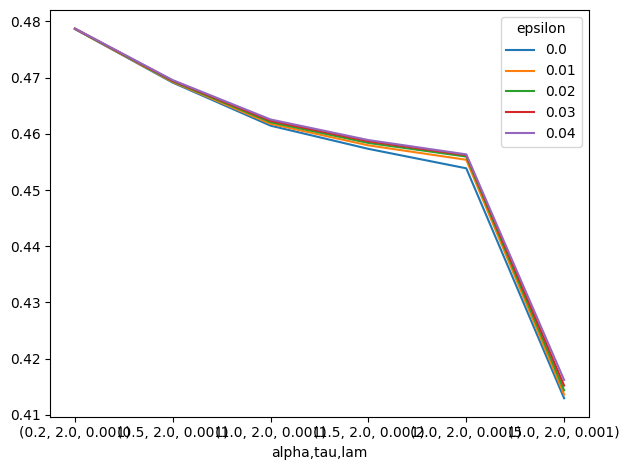

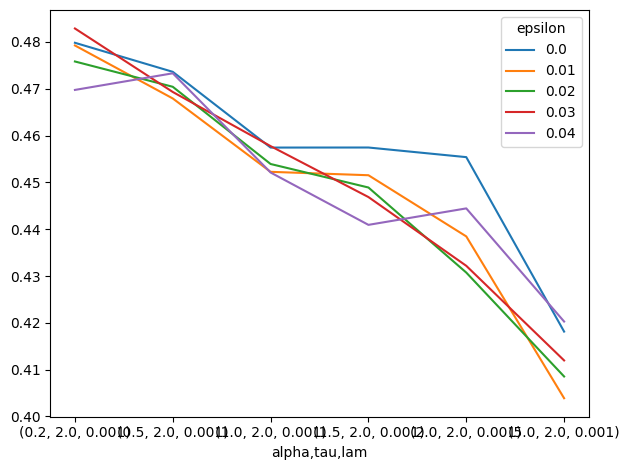

In [127]:
# plot generalization_error_state_evolution vs alpha
df["generalization_error_state_evolution"]["mean"].unstack(level=1).plot()
df["generalization_error_erm_erm"]["mean"].unstack(level=1).plot()

<AxesSubplot: xlabel='alpha,tau,lam'>

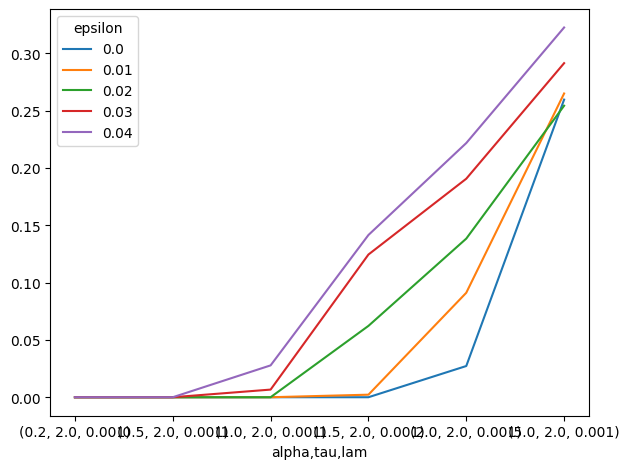

In [128]:
# plot the training_error vs alpha
df["training_error_erm"]["mean"].unstack(level=1).plot()

In [84]:
# Create a SweepExperiment
experiment = get_default_experiment()
# use json dump to save the experiment parameters
with open("sweep_experiment.json","w") as f:
    # use the NumpyEncoder to encode numpy arrays
    json.dump(experiment.__dict__,f,cls=NumpyEncoder)